In [1]:
import torch
import torchvision
from torch import nn
from perceiver_pytorch import Perceiver
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import itertools

In [2]:
model = Perceiver(
    input_channels = 1,          # number of channels for each token of the input
    input_axis = 2,              # number of axis for input data (2 for images, 3 for video)
    num_freq_bands = 6,          # number of freq bands, with original value (2 * K + 1)
    max_freq = 10.,              # maximum frequency, hyperparameter depending on how fine the data is
    freq_base = 2,
    depth = 2,                   # depth of net. The shape of the final attention mechanism will be:
                                 #   depth * (cross attention -> self_per_cross_attn * self attention)
    num_latents = 128,           # number of latents, or induced set points, or centroids. different papers giving it different names
    latent_dim = 256,            # latent dimension
    cross_heads = 1,             # number of heads for cross attention. paper said 1
    latent_heads = 2,            # number of heads for latent self attention, 8
    cross_dim_head = 32,         # number of dimensions per cross attention head
    latent_dim_head = 32,        # number of dimensions per latent self attention head
    num_classes = 10,          # output number of classes
    attn_dropout = 0.,
    ff_dropout = 0.,
    weight_tie_layers = False,   # whether to weight tie layers (optional, as indicated in the diagram)
    fourier_encode_data = True,  # whether to auto-fourier encode the data, using the input_axis given. defaults to True, but can be turned off if you are fourier encoding the data yourself
    self_per_cross_attn = 2      # number of self attention blocks per cross attention
)

img = torch.randn(1, 28, 28, 1) # 1 imagenet image, pixelized

model(img).shape # (1, 1000)

torch.Size([1, 10])

In [3]:
# imagenet_data = torchvision.datasets.ImageNet('/home/gabriel/Documents/datasets/')
# data_loader = torch.utils.data.DataLoader(imagenet_data,
#                                           batch_size=32,
#                                           shuffle=True,
#                                           num_workers=20)
# train_loader, val_loader, test_loader

In [4]:
# train_data = torch.utils.data.TensorDataset(torch.randn(100, 224, 224, 3), torch.randn(100, 1000))
# val_data = torch.utils.data.TensorDataset(torch.randn(100, 224, 224, 3), torch.randn(100, 1000))
# test_data = torch.utils.data.TensorDataset(torch.randn(100, 224, 224, 3), torch.randn(100, 1000))

# bs = 16
# train_loader = torch.utils.data.DataLoader(train_data,
#                                            batch_size=bs,
#                                            shuffle=True,
#                                            num_workers=20)
# val_loader = torch.utils.data.DataLoader(val_data,
#                                            batch_size=bs,
#                                            shuffle=False,
#                                            num_workers=20)
# test_loader = torch.utils.data.DataLoader(test_data,
#                                            batch_size=bs,
#                                            shuffle=False,
#                                            num_workers=20)

In [5]:
torch.manual_seed(0)

batch_size = 16

mnist_train = torchvision.datasets.MNIST('/home/gabriel/Documents/datasets/MNIST/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
train_set, val_set = torch.utils.data.random_split(mnist_train, [50000, 10000])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=10)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=10)
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/home/gabriel/Documents/datasets/MNIST/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size, shuffle=True, num_workers=10)

/home/gabriel/miniconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)
torch.backends.cudnn.benchmark = True

max_epochs = 50

model.to(device)
criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
val_loss_min = 100000.0

loss_thresh = 0
for epoch in range(max_epochs):
    train_loss = 0.0
    val_loss = 0.0
    
    model.train()
    loss_sum = 0
    loss_count = 0
    
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        X_batch = torch.transpose(torch.transpose(X_batch, 1, 2), 2, 3)
#         from matplotlib import pyplot as plt
#         plt.imshow(X_batch[0].cpu().numpy())
#         plt.show()
#         print(X_batch.shape, y_batch.shape)
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.data
        
    model.eval()
    with torch.no_grad():
        for batch_idx, (X_batch, y_batch) in enumerate(val_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            X_batch = torch.transpose(torch.transpose(X_batch, 1, 2), 2, 3)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.data

    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, 
        train_loss,
        val_loss
    ))
    
    checkpoint = {
        'epoch': epoch + 1,
        'valid_loss_min': val_loss,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(checkpoint, f'./checkpoint.pt')
    if val_loss <= val_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_min,val_loss))
        torch.save(checkpoint, './best_checkpoint.pt')
        val_loss_min = val_loss

cuda:0
Epoch: 0 	Training Loss: 0.052939 	Validation Loss: 0.017540
Validation loss decreased (100000.000000 --> 0.017540).  Saving model ...
Epoch: 1 	Training Loss: 0.016023 	Validation Loss: 0.017583


0.9156
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       980
           1       0.96      0.99      0.97      1135
           2       0.92      0.91      0.92      1032
           3       0.90      0.87      0.89      1010
           4       0.92      0.93      0.93       982
           5       0.86      0.86      0.86       892
           6       0.91      0.93      0.92       958
           7       0.88      0.95      0.91      1028
           8       0.92      0.86      0.89       974
           9       0.95      0.86      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.92      0.92      0.92     10000



<Figure size 432x288 with 0 Axes>

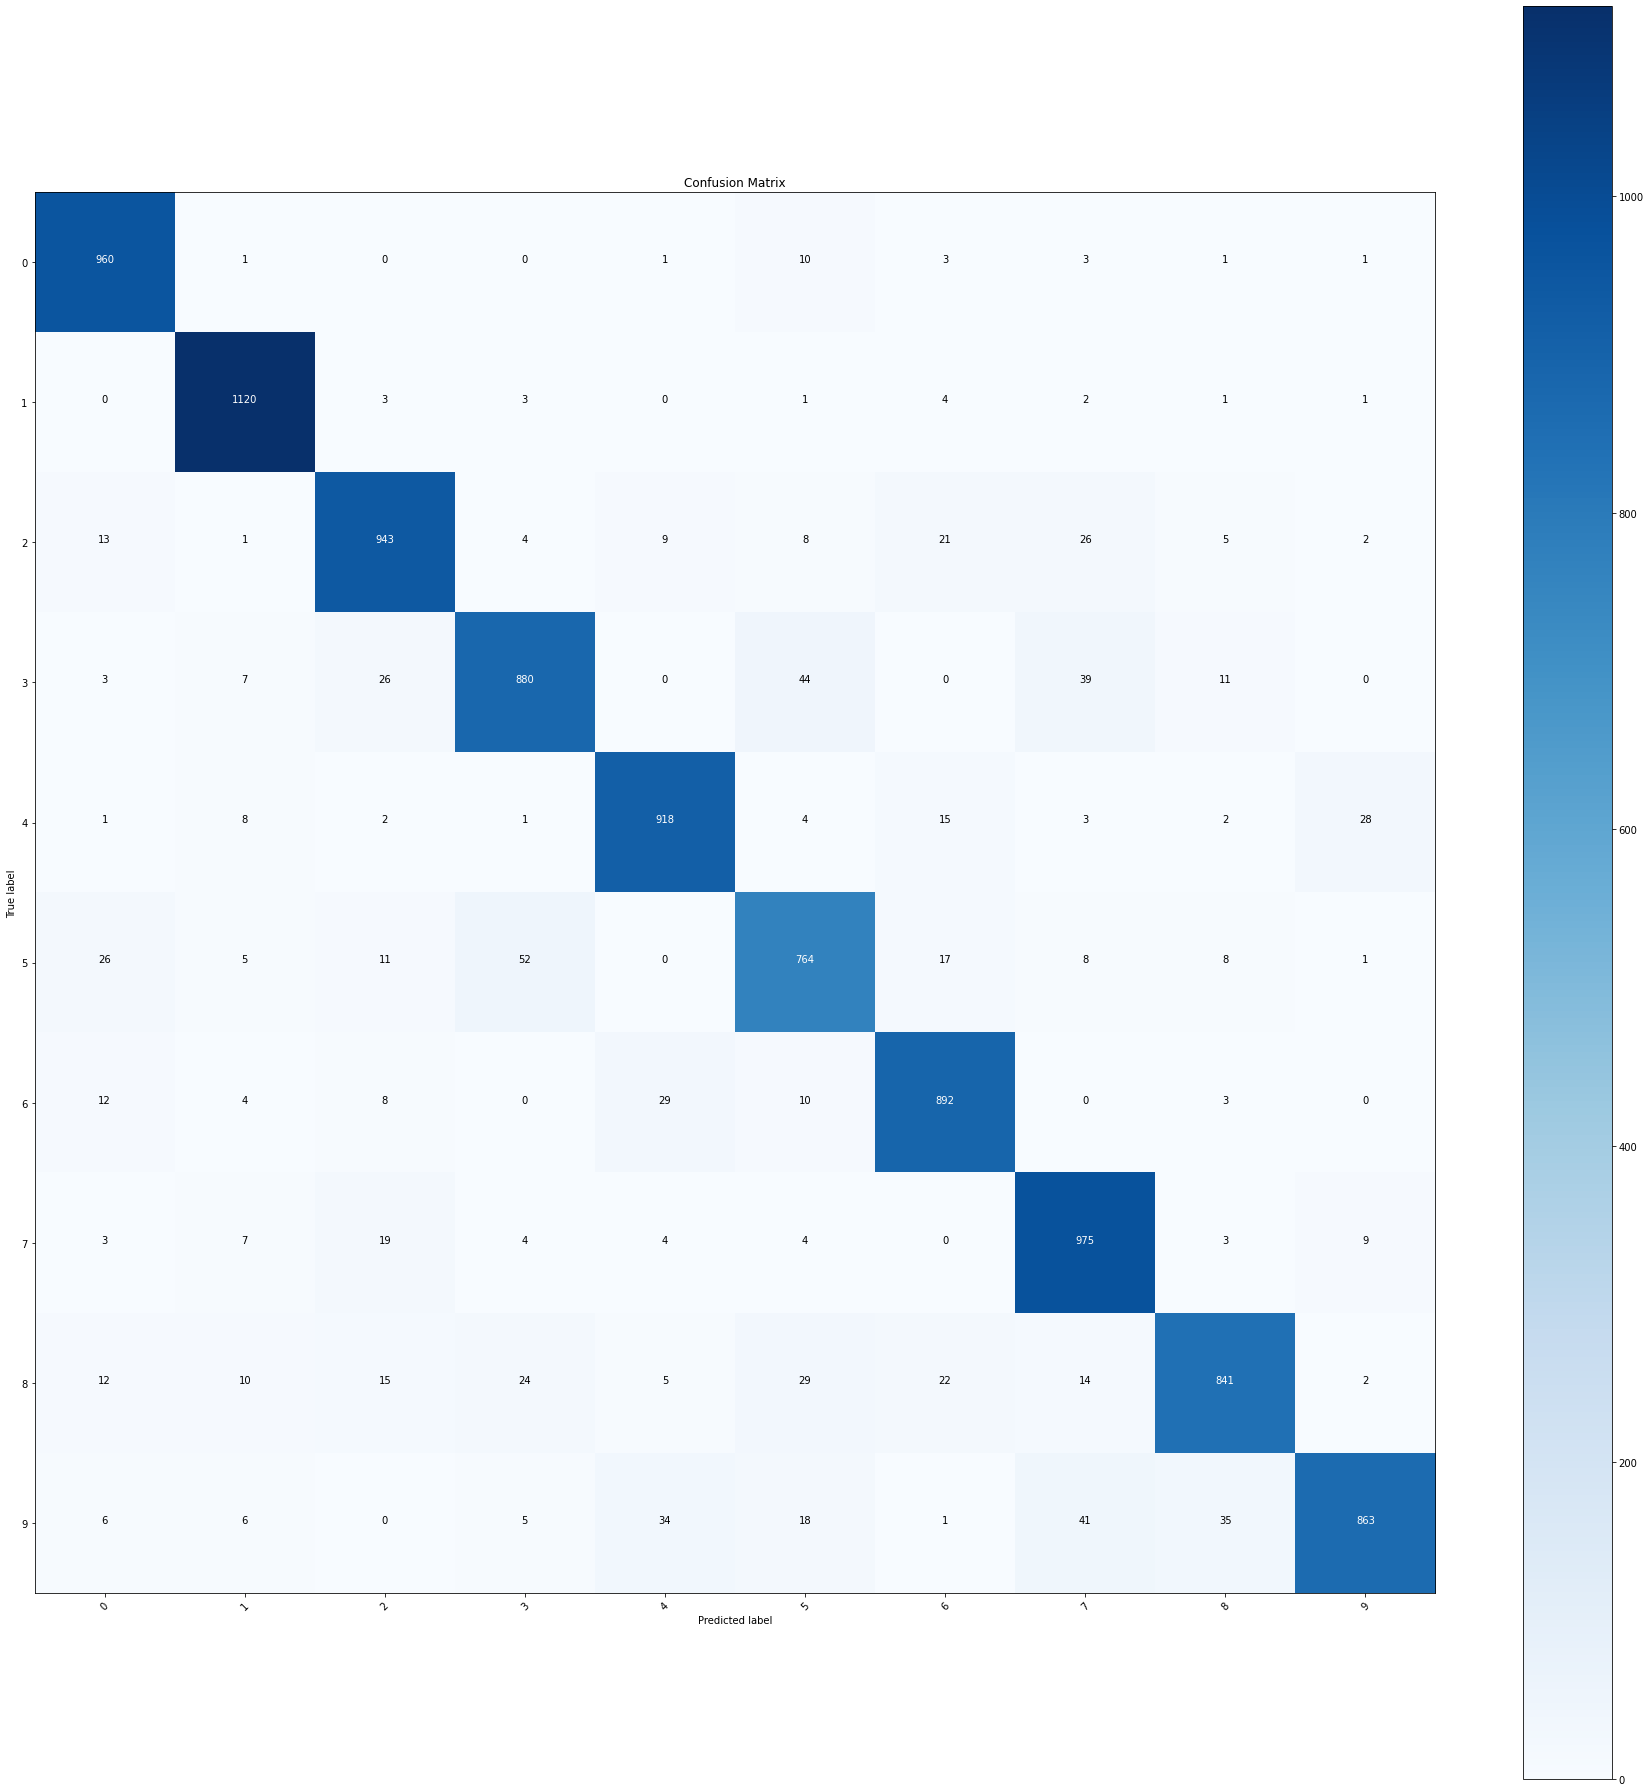

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
model.to(device)
checkpoint = torch.load('./best_checkpoint.pt')
model.load_state_dict(checkpoint['state_dict'])
model.eval()
m = nn.Softmax(dim=1)
y_pred_extended = []
y_true_extended = []
with torch.no_grad():
    for batch_idx, (X_batch, y_batch) in enumerate(test_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        X_batch = torch.transpose(torch.transpose(X_batch, 1, 2), 2, 3)
        y_pred = model(X_batch).cpu()
        #         print(y_pred)
        y_pred = m(y_pred)
        #         print(y_pred)
        y_pred = np.argmax(y_pred, axis=1)
        #         print(y_pred, y_batch.cpu())
        y_pred_extended.extend(y_pred)
        y_true_extended.extend(y_batch.cpu())
        
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)
    
    plt.figure(figsize=(25,25))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
accuracy = accuracy_score(y_pred_extended, y_true_extended)
cr = classification_report(y_true_extended, y_pred_extended)
print(accuracy)
print(cr)
cnf_matrix = confusion_matrix(y_true_extended, y_pred_extended)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[str(i) for i in list(range(10))], title = ('Confusion Matrix'))
plt.show()

In [ ]:
# model = Perceiver(
#     input_channels = 3,          # number of channels for each token of the input
#     input_axis = 2,              # number of axis for input data (2 for images, 3 for video)
#     num_freq_bands = 6,          # number of freq bands, with original value (2 * K + 1)
#     max_freq = 10.,              # maximum frequency, hyperparameter depending on how fine the data is
#     freq_base = 2,
#     depth = 2,                   # depth of net. The shape of the final attention mechanism will be:
#                                  #   depth * (cross attention -> self_per_cross_attn * self attention)
#     num_latents = 128,           # number of latents, or induced set points, or centroids. different papers giving it different names
#     latent_dim = 256,            # latent dimension
#     cross_heads = 1,             # number of heads for cross attention. paper said 1
#     latent_heads = 2,            # number of heads for latent self attention, 8
#     cross_dim_head = 32,         # number of dimensions per cross attention head
#     latent_dim_head = 32,        # number of dimensions per latent self attention head
#     num_classes = 1000,          # output number of classes
#     attn_dropout = 0.,
#     ff_dropout = 0.,
#     weight_tie_layers = False,   # whether to weight tie layers (optional, as indicated in the diagram)
#     fourier_encode_data = True,  # whether to auto-fourier encode the data, using the input_axis given. defaults to True, but can be turned off if you are fourier encoding the data yourself
#     self_per_cross_attn = 2      # number of self attention blocks per cross attention
# )

# print(len(model.layers))

In [ ]:
# model.layers.append(model.layers[1])
# print(len(model.layers))